In [1]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

# to avoid printing warnings
#import warnings
#warnings.filterwarnings('ignore')

# To avoid printing tsfresh warnings
#import logging
#logger = logging.getLogger()
#ogger.setLevel(logging.CRITICAL)

In [2]:
# Models
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from fbprophet import Prophet

# tsfresh functions
from tsfresh.feature_extraction import extract_features, EfficientFCParameters
#from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute

# Function for lags generating
from scipy.ndimage.interpolation import shift

# metrics
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

# Extra functions

In [3]:
def plot_results(time_series, Time, train_prediction, test_prediction, y_test, mode, description):
    
    """
    Plots the original time series and it prediction
    """
    if mode == 'prophet':
        ts = time_series["y"].values
        train_pr = train_prediction["yhat"].values
        test_pr = test_prediction["yhat"].values
    
    elif mode == 'pyramid':
        train_pr = train_prediction
        test_pr = test_prediction
        ts = time_series
        
    
    else:
        print("Check mode")
        return None
    
    plt.figure(figsize=(10,7))

    plt.plot(Time, ts, label = "true")
    
    #print(train_pr.shape, test_pr.shape, Time[start_point: end_point].shape)
    plt.plot(Time[start_point: end_point], np.concatenate([train_pr, test_pr]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(
             np.round(mean_absolute_percentage_error(test_pr, y_test), 3),
             np.round(mean_absolute_error(test_pr, y_test), 3)))


    plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

    plt.xlabel("time", size = 20)
    plt.ylabel("value", size = 20)
    plt.title("{}".format(description), size = 20)


    plt.legend(fontsize = 15)

    plt.show()
    pass

In [4]:
def fit(model, data_train, dict_of_features, max_timeshift = 5, rolling_direction = 1):

    """
    Method to fit model
    Args:
        y (pd.Series): time series to train 
    """

    data_train_with_zero = data_train.append({"y": 0, "ds": data_train["ds"].iloc[-1]}, ignore_index=True)

    df_shift, y = make_forecasting_frame(data_train_with_zero["y"].values, kind = "price",
                        max_timeshift = 50, rolling_direction = 1)

    X_train = extract_features(df_shift, column_id="id", column_sort="time", 
                                    column_value="value", impute_function=impute, show_warnings=False,
                                    disable_progressbar = True,
                              default_fc_parameters = dict_of_features, )

    X_train.dropna(axis = 1, inplace = True)
    
    final_train = pd.concat([data_train_with_zero.iloc[1:], X_train], axis = 1)

    #model = Prophet(seasonality_mode = 'additive')
    
    # Add regressors
    for it in (set(final_train.columns) - set(['ds', 'y'])):
        model.add_regressor(it)
    
    # Fit the model
    model.fit(final_train.iloc[:-1:1])

    return final_train

In [5]:
def predict(model, final_train, data_train, data_test):
        
    """
    Predicting values for data test
    """
    
    y_pred = model.predict(pd.DataFrame(final_train.iloc[-1][None, :], columns=final_train.columns))

    data_test_with_pred = data_train.append({
                            "y": y_pred["yhat"][0], "ds": data_test["ds"].iloc[0]}, ignore_index=True)

    for it in tqdm(range(1, data_test.shape[0])):

        df_shift, y = make_forecasting_frame(data_test_with_pred["y"].values, kind = "price",
                        max_timeshift = 50, rolling_direction = 1)

        X_test = extract_features(df_shift, column_id="id", column_sort="time", 
                                    column_value="value", impute_function=impute, show_warnings=False,
                                    disable_progressbar = True,
                                 default_fc_parameters = dict_of_features, )

        X_test.dropna(axis = 1, inplace = True)

        final_test = pd.concat([data_test_with_pred.iloc[1:], X_test], axis = 1)

        y_pred = model.predict(pd.DataFrame(final_test.iloc[-1][None, :], columns=final_test.columns))

        data_test_with_pred = data_test_with_pred.append(
                                    {"y": y_pred["yhat"][0], "ds": data_test["ds"].iloc[it]}, ignore_index=True)

    return data_test_with_pred
        

# Load data

In [6]:
train = pd.read_csv("../Datasets/Rossman Store Sales/train.csv", 
                    parse_dates = [2], low_memory = False)

test = pd.read_csv("../Datasets/Rossman Store Sales/test.csv", 
                    parse_dates = [2], low_memory = False)

store = pd.read_csv("../Datasets/Rossman Store Sales/store.csv", 
                    low_memory = False)

In [7]:
print(train["Date"][0])
train.head(5)

2015-07-31 00:00:00


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


# Only for the first store

In [8]:
store_1 = train[train["Store"] == 1].copy()
print(store_1.shape)
store_1 = store_1.iloc[-1::-1].copy()
store_1.head(5)

(942, 9)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1016095,1,2,2013-01-01,0,0,0,0,a,1
1014980,1,3,2013-01-02,5530,668,1,0,0,1
1013865,1,4,2013-01-03,4327,578,1,0,0,1
1012750,1,5,2013-01-04,4486,619,1,0,0,1
1011635,1,6,2013-01-05,4997,635,1,0,0,1


In [9]:
# delete zeros values
store_1 = store_1.iloc[store_1["Sales"].values != 0]

# reset index
store_1.reset_index(inplace = True)
store_1.head(5)

,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1014980,1,3,2013-01-02,5530,668,1,0,0,1
1,1013865,1,4,2013-01-03,4327,578,1,0,0,1
2,1012750,1,5,2013-01-04,4486,619,1,0,0,1
3,1011635,1,6,2013-01-05,4997,635,1,0,0,1
4,1009405,1,1,2013-01-07,7176,785,1,1,0,1


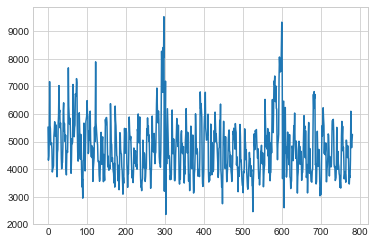

In [10]:
plt.plot(store_1["Sales"].values)

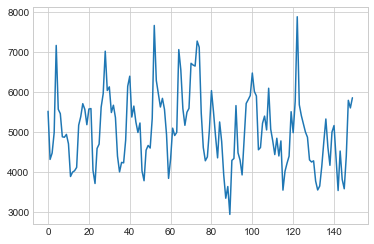

In [11]:
g = store_1["Sales"].values != 0
plt.plot(store_1.iloc[g]["Sales"].values[:150])

# Train-test split

In [12]:
data = store_1[["Date", "Sales"]]
data.columns = ['ds', 'y']
data.head(5)

,ds,y
0,2013-01-02,5530
1,2013-01-03,4327
2,2013-01-04,4486
3,2013-01-05,4997
4,2013-01-07,7176


In [13]:
exog = store_1[["Date", "Open"]]
exog.columns = ['ds', 'Open']
exog.head(5)

,ds,Open
0,2013-01-02,1
1,2013-01-03,1
2,2013-01-04,1
3,2013-01-05,1
4,2013-01-07,1


In [14]:
data.shape

(781, 2)

In [15]:
mode = 'prophet'
start_point = 200
middle_point = 400
#end_point = data.shape[0]
end_point = 450
Time = data.index.values

data_train = data.iloc[start_point: middle_point]
data_test = data.iloc[middle_point: end_point]

exog_train = exog.iloc[start_point: middle_point]
exog_test = exog.iloc[middle_point: end_point]

In [16]:
data_train_new = pd.merge(data_train, exog_train, on='ds')
data_test_new = pd.merge(data_test, exog_test, on='ds')

In [17]:
y_test = data_test_new["y"].copy()
del data_test_new["y"]

# Prophet without tsfresh

In [18]:
model = Prophet()
#model.add_regressor('Open')

In [19]:
model.fit(data_train)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [20]:
train_prediction = model.predict(data_train)
test_prediction = model.predict(data_test)

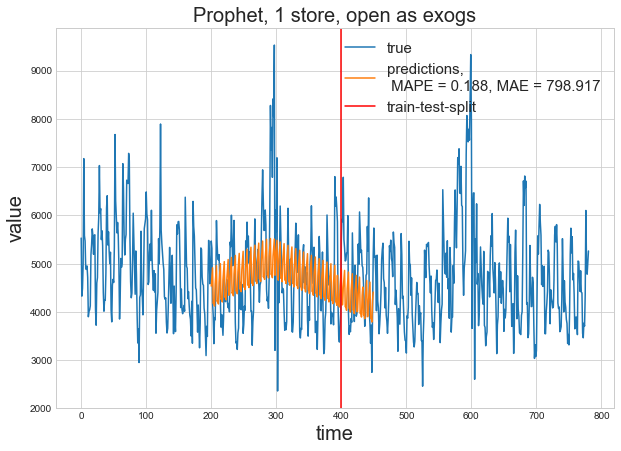

In [21]:
description = 'Prophet, 1 store, open as exogs'
plot_results(data, Time, train_prediction, test_prediction, y_test, mode, description)

# Prophet with tsfresh without lags

In [22]:
dict_of_features  = EfficientFCParameters()

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/feature_extraction/settings.py:106: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if callable(func) and hasattr(func, "fctype") and len(getargspec(func).args) == 1:


In [23]:
model = Prophet()
final_train = fit(model, data_train, dict_of_features)

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [24]:
test_predictions_tsfresh = predict(model, final_train, data_train, data_test)

  0%|          | 0/49 [00:00<?, ?it/s]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercep

  2%|▏         | 1/49 [00:14<11:31, 14.41s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"

  4%|▍         | 2/49 [00:30<11:59, 15.32s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"

  6%|▌         | 3/49 [00:45<11:36, 15.14s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"

  8%|▊         | 4/49 [00:59<11:14, 14.99s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"

 10%|█         | 5/49 [01:14<10:55, 14.89s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"

 12%|█▏        | 6/49 [01:29<10:39, 14.86s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"

 14%|█▍        | 7/49 [01:43<10:23, 14.84s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"

 16%|█▋        | 8/49 [01:58<10:07, 14.81s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"

 18%|█▊        | 9/49 [02:13<09:52, 14.81s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"

 20%|██        | 10/49 [02:28<09:37, 14.80s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 22%|██▏       | 11/49 [02:42<09:22, 14.80s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 24%|██▍       | 12/49 [02:58<09:09, 14.84s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 27%|██▋       | 13/49 [03:13<08:54, 14.86s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 29%|██▊       | 14/49 [03:28<08:40, 14.86s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 31%|███       | 15/49 [03:43<08:25, 14.88s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 33%|███▎      | 16/49 [03:58<08:11, 14.89s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 35%|███▍      | 17/49 [04:13<07:56, 14.90s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 37%|███▋      | 18/49 [04:28<07:42, 14.92s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 39%|███▉      | 19/49 [04:43<07:28, 14.94s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 41%|████      | 20/49 [05:00<07:15, 15.01s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 43%|████▎     | 21/49 [05:16<07:02, 15.09s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 45%|████▍     | 22/49 [05:32<06:48, 15.13s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 47%|████▋     | 23/49 [05:48<06:34, 15.16s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 49%|████▉     | 24/49 [06:04<06:19, 15.19s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 51%|█████     | 25/49 [06:21<06:05, 15.24s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 53%|█████▎    | 26/49 [06:37<05:51, 15.30s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 55%|█████▌    | 27/49 [06:55<05:38, 15.38s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 57%|█████▋    | 28/49 [07:14<05:25, 15.51s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 59%|█████▉    | 29/49 [07:31<05:11, 15.56s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 61%|██████    | 30/49 [07:47<04:56, 15.60s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 63%|██████▎   | 31/49 [08:04<04:41, 15.64s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 65%|██████▌   | 32/49 [08:20<04:26, 15.65s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 67%|██████▋   | 33/49 [08:37<04:10, 15.68s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 69%|██████▉   | 34/49 [08:54<03:55, 15.73s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 71%|███████▏  | 35/49 [09:11<03:40, 15.74s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 73%|███████▎  | 36/49 [09:27<03:25, 15.77s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 76%|███████▌  | 37/49 [09:44<03:09, 15.79s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 78%|███████▊  | 38/49 [10:00<02:53, 15.81s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 80%|███████▉  | 39/49 [10:18<02:38, 15.85s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 82%|████████▏ | 40/49 [10:35<02:22, 15.88s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 84%|████████▎ | 41/49 [10:53<02:07, 15.94s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 86%|████████▌ | 42/49 [11:10<01:51, 15.96s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 88%|████████▊ | 43/49 [11:26<01:35, 15.97s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 90%|████████▉ | 44/49 [11:42<01:19, 15.98s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 92%|█████████▏| 45/49 [11:59<01:03, 15.99s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 94%|█████████▍| 46/49 [12:16<00:48, 16.01s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 96%|█████████▌| 47/49 [12:33<00:32, 16.02s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

 98%|█████████▊| 48/49 [12:50<00:16, 16.04s/it]/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_

100%|██████████| 49/49 [13:07<00:00, 16.07s/it]


In [29]:
y_test.shape

(50,)

In [42]:
rolling_predictions[middle_point - start_point: end_point-start_point].shape

(50,)

In [37]:
middle_point, end_point

(400, 450)

In [40]:
rolling_predictions[: 4]

array([], dtype=float64)

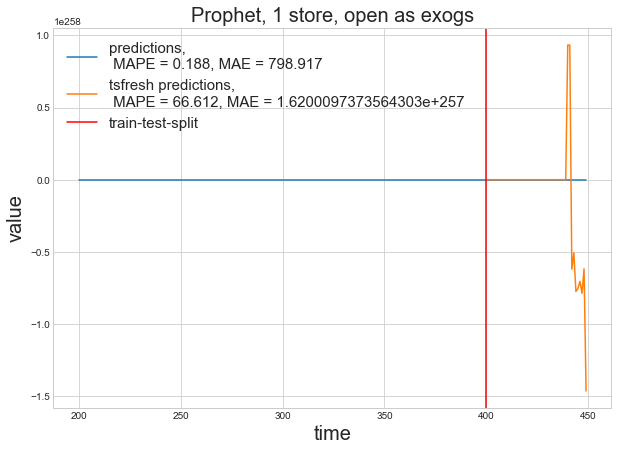

In [54]:
ts = data["y"].values

train_pr = train_prediction["yhat"].values
test_pr = test_prediction["yhat"].values

rolling_predictions = test_predictions_tsfresh["y"].values[middle_point - start_point: end_point-start_point]

plt.figure(figsize=(10,7))

#plt.plot(Time, ts, label = "true")

plt.plot(Time[start_point: end_point], np.concatenate([train_pr, test_pr]), 
     label = "predictions, \n MAPE = {0}, MAE = {1}".format(
         np.round(mean_absolute_percentage_error(test_pr, y_test), 3),
         np.round(mean_absolute_error(test_pr, y_test), 3)))


plt.plot(Time[middle_point: end_point], rolling_predictions, 
     label = "tsfresh predictions, \n MAPE = {0}, MAE = {1}".format(
         np.round(mean_absolute_percentage_error(
                         rolling_predictions, y_test), 3),
         np.round(mean_absolute_error(
                         rolling_predictions, y_test), 3)))

plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title("{}".format(description), size = 20)


plt.legend(fontsize = 15)

plt.show()

# Prophet with lags

In [22]:
y_train = data_train_new["y"].values
y_train

array([5469, 5317, 4195, 3928, 3343, 3883, 3836, 4663, 5893, 5403, 5103,
       5079, 5187, 4663, 4249, 3685, 3946, 3717, 3516, 3909, 4770, 4274,
       4212, 4481, 4669, 4175, 4088, 4178, 4001, 5447, 5352, 6004, 5452,
       4957, 5286, 5896, 4954, 3773, 3355, 3383, 3223, 3566, 3667, 5055,
       4068, 4612, 4044, 4573, 4347, 3557, 3737, 4119, 4035, 5471, 5233,
       5861, 5348, 5572, 5009, 5242, 4681, 4014, 4017, 3310, 3795, 4016,
       5071, 5927, 5143, 4936, 4623, 5058, 5297, 4600, 4201, 4561, 4614,
       5623, 6373, 6943, 6293, 5688, 5691, 6112, 5799, 4462, 4228, 4301,
       4074, 4703, 6119, 8277, 7356, 7821, 6788, 8414, 8043, 9528, 3204,
       6110, 5659, 7193, 2362, 4969, 4190, 5173, 6194, 5539, 4931, 4396,
       4486, 4454, 3994, 3621, 3776, 3632, 3803, 5128, 6148, 5151, 4562,
       4597, 5098, 4546, 3601, 3581, 3789, 4549, 4906, 5292, 5839, 5540,
       5031, 4823, 5596, 4726, 3591, 3461, 3662, 3638, 4647, 5258, 5393,
       4602, 4935, 4563, 4727, 4820, 3826, 3499, 41

In [23]:
exog_lag = np.hstack((shift(np.concatenate([y_train,[0]]),shift = 1, cval = 0.0).reshape(-1,1),
shift(np.concatenate([y_train,[0]]),shift = 2, cval = 0.0).reshape(-1,1),
shift(np.concatenate([y_train,[0]]),shift = 3, cval = 0.0).reshape(-1,1),
shift(np.concatenate([y_train,[0]]),shift = 4, cval = 0.0).reshape(-1,1),
shift(np.concatenate([y_train,[0]]),shift = 5, cval = 0.0).reshape(-1,1), 
shift(np.concatenate([y_train,[0]]),shift = 6, cval = 0.0).reshape(-1,1)))

In [24]:
exog_lag = pd.DataFrame(exog_lag, columns = ['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6'])
exog_lag.head(5)

,lag1,lag2,lag3,lag4,lag5,lag6
0,0,0,0,0,0,0
1,5469,0,0,0,0,0
2,5317,5469,0,0,0,0
3,4195,5317,5469,0,0,0
4,3928,4195,5317,5469,0,0


In [68]:
def fit_with_lags(model, data_train, dict_of_features, max_timeshift = 5, rolling_direction = 1):

    """
    Method to fit model
    Args:
        y (pd.Series): time series to train 
    """

    data_train_with_zero = data_train.append({"y": 0, "ds": data_train["ds"].iloc[-1]}, ignore_index=True)

    #df_shift, y = make_forecasting_frame(data_train_with_zero["y"].values, kind = "price",
    #                    max_timeshift = 50, rolling_direction = 1)
    
    y_train = data_train_with_zero["y"].values
    
    exog_lag = np.hstack((shift(y_train, shift = 1, cval = 0.0).reshape(-1,1),
                            shift(y_train, shift = 2, cval = 0.0).reshape(-1,1),
                            shift(y_train, shift = 3, cval = 0.0).reshape(-1,1),
                            shift(y_train, shift = 4, cval = 0.0).reshape(-1,1),
                            shift(y_train, shift = 5, cval = 0.0).reshape(-1,1), 
                            shift(y_train, shift = 6, cval = 0.0).reshape(-1,1)))
    
    exog_lag = pd.DataFrame(exog_lag, columns = ['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6'])
    
    #X_train = extract_features(df_shift, column_id="id", column_sort="time", 
    #                                column_value="value", impute_function=impute, show_warnings=False,
    #                                disable_progressbar = True,
    #                          default_fc_parameters = dict_of_features, )

    #X_train.dropna(axis = 1, inplace = True)
    
    #final_train = pd.concat([data_train_with_zero.iloc[1:], X_train], axis = 1)
    
    final_train = pd.concat([data_train_with_zero, exog_lag], axis = 1)

    #model = Prophet(seasonality_mode = 'additive')
    
    # Add regressors
    for it in (set(final_train.columns) - set(['ds', 'y'])):
        model.add_regressor(it, mode='multiplicative')
    
    # Fit the model
    model.fit(final_train.iloc[:-1:1])

    return final_train

In [69]:
def predict_with_lags(model, final_train, data_train, data_test):
        
    """
    Predicting values for data test
    """
    
    y_pred = model.predict(pd.DataFrame(final_train.iloc[-1][None, :], columns=final_train.columns))
    
    data_test_with_pred = data_train.append({
                            "y": y_pred["yhat"][0], "ds": data_test["ds"].iloc[0]}, ignore_index=True)

    
    for it in tqdm(range(1, data_test.shape[0])):

        #df_shift, y = make_forecasting_frame(data_test_with_pred["y"].values, kind = "price",
        #                max_timeshift = 50, rolling_direction = 1)

        #X_test = extract_features(df_shift, column_id="id", column_sort="time", 
        #                            column_value="value", impute_function=impute, show_warnings=False,
        #                            disable_progressbar = True,
        #                         default_fc_parameters = dict_of_features, )

        #X_test.dropna(axis = 1, inplace = True)

        
        y_test = data_test_with_pred["y"].values
    
        exog_lag = np.hstack((shift(y_test, shift = 1, cval = 0.0).reshape(-1,1),
                            shift(y_test, shift = 2, cval = 0.0).reshape(-1,1),
                            shift(y_test, shift = 3, cval = 0.0).reshape(-1,1),
                            shift(y_test, shift = 4, cval = 0.0).reshape(-1,1),
                            shift(y_test, shift = 5, cval = 0.0).reshape(-1,1), 
                            shift(y_test, shift = 6, cval = 0.0).reshape(-1,1)))
    
        exog_lag = pd.DataFrame(exog_lag, columns = ['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6'])
    
    
        final_test = pd.concat([data_test_with_pred, exog_lag], axis = 1)
        
        
        #final_test = pd.concat([data_test_with_pred.iloc[1:], X_test], axis = 1)

        y_pred = model.predict(pd.DataFrame(final_test.iloc[-1][None, :], columns=final_test.columns))

        data_test_with_pred = data_test_with_pred.append(
                                    {"y": y_pred["yhat"][0], "ds": data_test["ds"].iloc[it]}, ignore_index=True)

    return data_test_with_pred
        

In [70]:
dict_of_features = EfficientFCParameters()

model = Prophet()
final_train = fit_with_lags(model, data_train, dict_of_features)

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/feature_extraction/settings.py:106: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if callable(func) and hasattr(func, "fctype") and len(getargspec(func).args) == 1:
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [71]:
model.params['beta'].shape

(1, 12)

In [72]:
predictions = predict_with_lags(model, final_train, data_train, data_test)

100%|██████████| 49/49 [01:17<00:00,  1.57s/it]


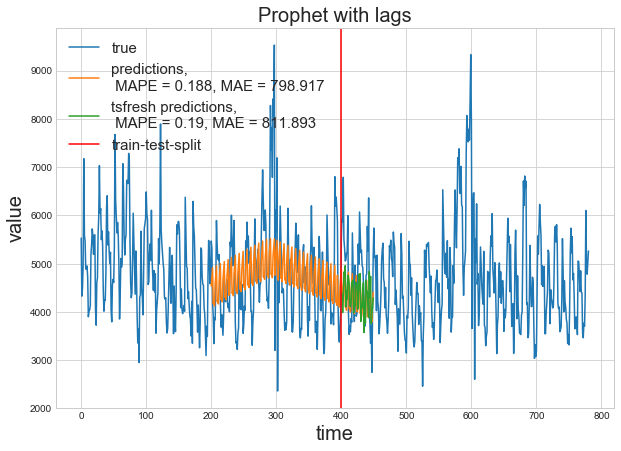

In [73]:
description = "Prophet with lags"

ts = data["y"].values

train_pr = train_prediction["yhat"].values
test_pr = test_prediction["yhat"].values

rolling_predictions = predictions["y"].values[middle_point - start_point: end_point-start_point]

plt.figure(figsize=(10,7))

plt.plot(Time, ts, label = "true")

plt.plot(Time[start_point: end_point], np.concatenate([train_pr, test_pr]), 
     label = "predictions, \n MAPE = {0}, MAE = {1}".format(
         np.round(mean_absolute_percentage_error(test_pr, y_test), 3),
         np.round(mean_absolute_error(test_pr, y_test), 3)))


plt.plot(Time[middle_point: end_point], rolling_predictions, 
     label = "tsfresh predictions, \n MAPE = {0}, MAE = {1}".format(
         np.round(mean_absolute_percentage_error(
                         rolling_predictions, y_test), 3),
         np.round(mean_absolute_error(
                         rolling_predictions, y_test), 3)))

plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title("{}".format(description), size = 20)


plt.legend(fontsize = 15)

plt.show()

**Немного увеличим график на тесте**

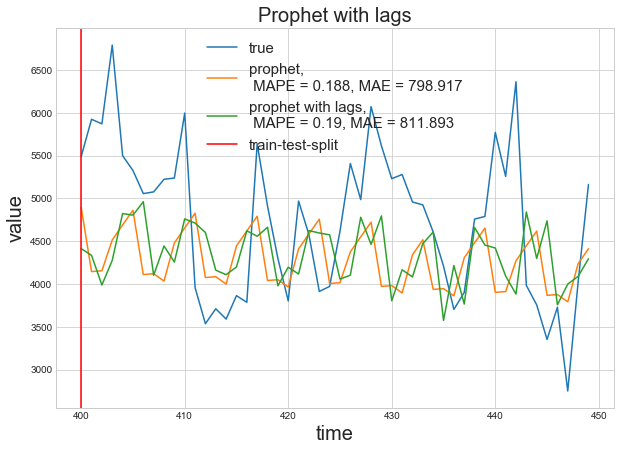

In [74]:
ts = data["y"].values

train_pr = train_prediction["yhat"].values
test_pr = test_prediction["yhat"].values

rolling_predictions = predictions["y"].values[middle_point - start_point: end_point-start_point]

plt.figure(figsize=(10,7))

plt.plot(Time[400: 450], ts[400: 450], label = "true")

plt.plot(Time[start_point: end_point][-50:], np.concatenate([train_pr, test_pr])[-50:], 
     label = "prophet, \n MAPE = {0}, MAE = {1}".format(
         np.round(mean_absolute_percentage_error(test_pr, y_test), 3),
         np.round(mean_absolute_error(test_pr, y_test), 3)))


plt.plot(Time[middle_point: end_point][-50:], rolling_predictions[-50:], 
    label = "prophet with lags, \n MAPE = {0}, MAE = {1}".format(
        np.round(mean_absolute_percentage_error(
                        rolling_predictions, y_test), 3),
        np.round(mean_absolute_error(
                        rolling_predictions, y_test), 3)))

plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title("{}".format(description), size = 20)


plt.legend(fontsize = 15)

plt.show()

**Можно заметить некоторые улучшения.**